<a href="https://colab.research.google.com/github/DavideScassola/PML2024/blob/main/./Notebooks/06_bayesian_LR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 6: Bayesian Linear Regression & Classification

Probabilistic Machine Learning -- Spring 2024, UniTS


In this notebook, we explore linear regression and classification from a Bayesian point of view. In both cases, we start implementing the classical formulation and then we switch to the Bayesian version. We can then compare the methods on a simple example.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Linear Regression

The first model that we implement is the well known linear regression model and we use the "linear algebra view" that we studied during the lessons.

As a case study, we use the [Kaggle dataset](https://www.kaggle.com/datasets/budincsevity/szeged-weather/data) about Weather in Szeged (Hungary) between 2006 and 2016 and we try to predict the apparent temperature given some predictors.



In [4]:
weatherHistory = pd.read_csv('https://raw.githubusercontent.com/DavideScassola/PML2024/main/Notebooks/data/weatherHistory.csv')
weatherHistory.head(5)

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [5]:
weatherHistory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


In [6]:
#Let's reduce the size of the dataset by considering one row for each day (corresponding to 16:00), only in 2015
#Training: April, Test: May
weatherHistory['Formatted Date'] = pd.to_datetime(weatherHistory['Formatted Date'], utc=True)
data = weatherHistory[((weatherHistory['Formatted Date'].dt.hour == 16) & (weatherHistory['Formatted Date'].dt.year == 2014) & (weatherHistory['Formatted Date'].dt.month == 4))].reset_index(drop=True)
data.info()
data_test = weatherHistory[((weatherHistory['Formatted Date'].dt.hour == 16) & (weatherHistory['Formatted Date'].dt.year == 2014) & (weatherHistory['Formatted Date'].dt.month == 5))].reset_index(drop=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   Formatted Date            30 non-null     datetime64[ns, UTC]
 1   Summary                   30 non-null     object             
 2   Precip Type               30 non-null     object             
 3   Temperature (C)           30 non-null     float64            
 4   Apparent Temperature (C)  30 non-null     float64            
 5   Humidity                  30 non-null     float64            
 6   Wind Speed (km/h)         30 non-null     float64            
 7   Wind Bearing (degrees)    30 non-null     float64            
 8   Visibility (km)           30 non-null     float64            
 9   Loud Cover                30 non-null     float64            
 10  Pressure (millibars)      30 non-null     float64            
 11  Daily Summary        

Text(0.5, 1.0, 'Apparent Temperature vs Humidity')

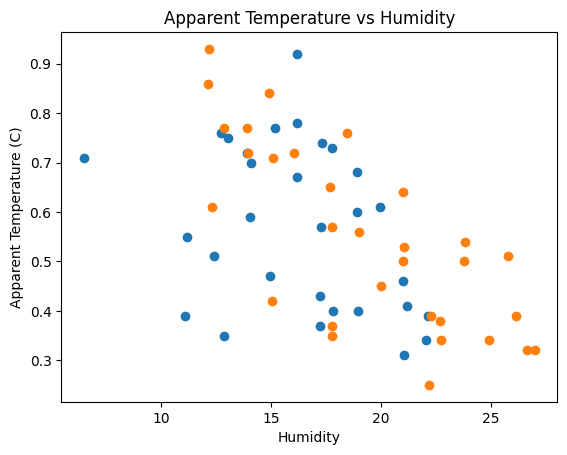

In [7]:
plt.scatter(data["Apparent Temperature (C)"], data["Humidity"], label = "train")
plt.scatter(data_test["Apparent Temperature (C)"], data_test["Humidity"], label = "test")

plt.xlabel("Humidity")
plt.ylabel("Apparent Temperature (C)")
plt.title("Apparent Temperature vs Humidity")

In order to perform the linear regression, we follow the maximum likelihood approach:
$$\theta_{ML} = \text{argmax } p(\underline{y} | \underline{x}, \theta)$$

and we define our parametric model as:
$$p(y|x, \theta) = \mathcal{N}(y|f(x,w), \beta^{-1})$$

where 

$$f(x,w) = w_0 \phi_0(x) + \ldots + w_{M-1}\phi_{M-1}(x)$$

with $\phi$ basis functions.

The weighs can be computed by:

$$w_M = \left( \Phi^T \Phi \right)^{-1} \Phi^T \underline{y}$$

where $\Phi$ is the design matrix.

In [50]:
def linear_basis(x):
    return x

def linear_regression(x,y,basis_function):
    
    N = len(y)
    train_features = basis_function(x)
   
    X = np.hstack((np.ones((N,1)), train_features))
    print(f'matrice delle features: {X}')
   
    A = np.linalg.inv(X.T @ X)
    D = A @ X.T
    w = D @ y
   
    return np.dot(X, w), w

def predict_linear_regression(x,N,w,basis_function):
    
    train_features = basis_function(x)
    X = np.hstack((np.ones((N,1)), train_features))
    return np.dot(X, w)

We can perform the linear regression on the dataset and compute:

- Mean Squared Error (MSE): $$\text{MSE} = \frac{1}{N} \sum_{i=1}^N (y_i - \hat{y}_i)^2$$
- Log Likelihood: $$\sum_i -\frac{1}{2} \log(2\pi\sigma_i^2) - \frac{(y_i - \mu_i)^2}{2\sigma_i^2}$$


X (Humidity) vs Y (Apparent Temperature):
10.0
X (Humidity) vs Y (Apparent Temperature) vs Y (prediction):
[[ 0.43       17.23888889 17.41631471]
 [ 0.71        6.47222222 15.18863284]
 [ 0.51       12.40555556 16.77983417]
 [ 0.47       14.97222222 17.09807444]
 [ 0.37       17.24444444 17.89367511]
 [ 0.75       13.01666667 14.87039257]
 [ 0.39       11.06111111 17.73455498]
 [ 0.55       11.16111111 16.46159391]
 [ 0.76       12.71666667 14.7908325 ]
 [ 0.67       16.18333333 15.5068731 ]
 [ 0.7        14.07222222 15.2681929 ]
 [ 0.4        17.82222222 17.65499491]
 [ 0.72       13.91111111 15.10907277]
 [ 0.46       20.99444444 17.17763451]
 [ 0.68       18.92777778 15.42731304]
 [ 0.61       19.97777778 15.98423351]
 [ 0.92       16.18333333 13.51787143]
 [ 0.78       16.17777778 14.63171237]
 [ 0.6        18.93333333 16.06379357]
 [ 0.31       21.06111111 18.37103551]
 [ 0.39       22.12777778 17.73455498]
 [ 0.74       17.3        14.94995264]
 [ 0.4        18.93888889 17.654994

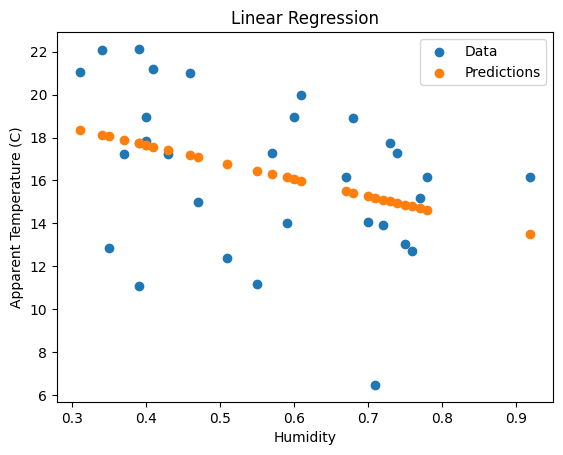

MSE:
15.003278972671396
Log Likelihood:
-164.16046416298286


In [34]:
#in this case x and y are row vectors, so we need to convert them to column vectors
x = data["Humidity"].to_numpy().reshape(-1,1)
y = data["Apparent Temperature (C)"].to_numpy().reshape(-1,1)

print("X (Humidity) vs Y (Apparent Temperature):")

beta = 0.01
print(np.sqrt(1/beta))

y_pred_linear, w = linear_regression(x,y,linear_basis)
print("X (Humidity) vs Y (Apparent Temperature) vs Y (prediction):")
print(np.hstack([x, y, y_pred_linear]))
print("w:")
print(w)

plt.scatter(data["Humidity"], data["Apparent Temperature (C)"], label = 'Data')
plt.scatter(data["Humidity"].to_numpy(), y_pred_linear, label = 'Predictions')
plt.xlabel("Humidity")
plt.ylabel("Apparent Temperature (C)")
plt.title("Linear Regression")
plt.legend()
plt.show()

print("MSE:")
print(np.mean((y_pred_linear.T-y)**2))
print("Log Likelihood:")
print(-len(y)/2*np.log(2*np.pi)-len(y)/2*np.log(1/beta) - 1/2*beta*np.sum((y_pred_linear.T-y)**2))

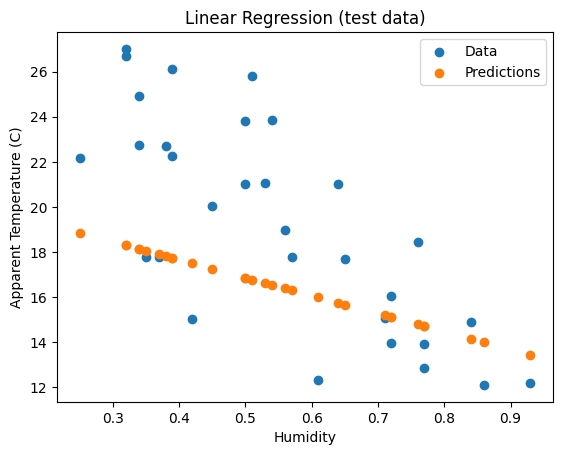

MSE:
31.098261165291554
Log Likelihood:
-249.29437731138614


In [35]:
#Let's see now on the test set

x_test = data_test["Humidity"].to_numpy().reshape(-1,1)
y_test = data_test["Apparent Temperature (C)"].to_numpy().reshape(-1,1)

y_test_pred= predict_linear_regression(x_test,len(x_test),w,linear_basis)

plt.scatter(data_test["Humidity"], data_test["Apparent Temperature (C)"], label = 'Data')
plt.scatter(data_test["Humidity"].to_numpy(), y_test_pred, label = 'Predictions')
plt.xlabel("Humidity")
plt.ylabel("Apparent Temperature (C)")
plt.title("Linear Regression (test data)")
plt.legend()
plt.show()

print("MSE:")
print(np.mean((y_test_pred.T-y_test)**2))
print("Log Likelihood:")
print(-len(y_test)/2*np.log(2*np.pi*1/beta) - 1/2*np.sum((y_test_pred.T-y_test)**2*beta))


[2 4 8]
matrice delle features: [[1.   0.43]
 [1.   0.71]
 [1.   0.51]
 [1.   0.47]
 [1.   0.37]
 [1.   0.75]
 [1.   0.39]
 [1.   0.55]
 [1.   0.76]
 [1.   0.67]
 [1.   0.7 ]
 [1.   0.4 ]
 [1.   0.72]
 [1.   0.46]
 [1.   0.68]
 [1.   0.61]
 [1.   0.92]
 [1.   0.78]
 [1.   0.6 ]
 [1.   0.31]
 [1.   0.39]
 [1.   0.74]
 [1.   0.4 ]
 [1.   0.73]
 [1.   0.34]
 [1.   0.77]
 [1.   0.59]
 [1.   0.57]
 [1.   0.41]
 [1.   0.35]]
matrice delle features: [[1.     0.1849]
 [1.     0.5041]
 [1.     0.2601]
 [1.     0.2209]
 [1.     0.1369]
 [1.     0.5625]
 [1.     0.1521]
 [1.     0.3025]
 [1.     0.5776]
 [1.     0.4489]
 [1.     0.49  ]
 [1.     0.16  ]
 [1.     0.5184]
 [1.     0.2116]
 [1.     0.4624]
 [1.     0.3721]
 [1.     0.8464]
 [1.     0.6084]
 [1.     0.36  ]
 [1.     0.0961]
 [1.     0.1521]
 [1.     0.5476]
 [1.     0.16  ]
 [1.     0.5329]
 [1.     0.1156]
 [1.     0.5929]
 [1.     0.3481]
 [1.     0.3249]
 [1.     0.1681]
 [1.     0.1225]]
matrice delle features: [[1.     0.6149]
 

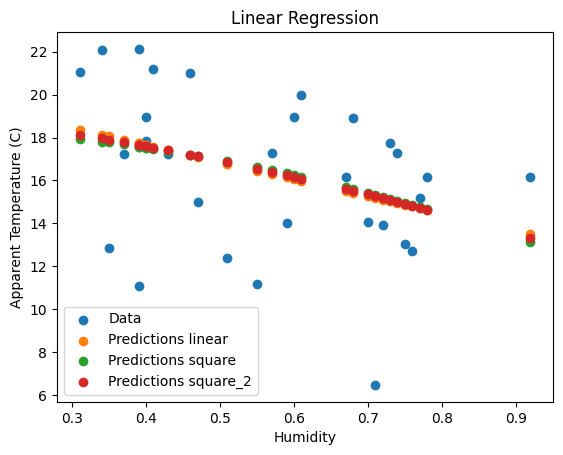

In [59]:
#Let's try to change the basis function

def square_basis(x):
    return  x**2   
def square_basis_5(x):
    return  x + x**2   
def square_basis_2(x):
    return np.hstack((x,x**2,x**3))
def square_basis_3(x):
    return np.hstack((x,x**2,x**3,x**4,x**5,x**6,x**7,x**8,x**9,x**10,x**11,x**12,x**13,x**14,x**15,x**16,x**17,x**18,x**19))

print(square_basis_2(2))

y_pred_1, w = linear_regression(x,y,linear_basis)
y_pred_2, w = linear_regression(x,y,square_basis)
y_pred_3, w = linear_regression(x,y,square_basis_5)
y_pred_4, w = linear_regression(x,y,square_basis_3)
# print('w:')
# print(w)

plt.scatter(data["Humidity"], data["Apparent Temperature (C)"], label = 'Data')
plt.scatter(data["Humidity"].to_numpy(), y_pred_1, label = 'Predictions linear')
plt.scatter(data["Humidity"].to_numpy(), y_pred_2, label = 'Predictions square')
plt.scatter(data["Humidity"].to_numpy(), y_pred_3, label = 'Predictions square_2')
# plt.scatter(data["Humidity"].to_numpy(), y_pred_4, label = 'Predictions square_3')
plt.xlabel("Humidity")
plt.ylabel("Apparent Temperature (C)")
plt.title("Linear Regression")
plt.legend()
plt.show()

# print("MSE:")
# print(np.mean((y_pred.T-y)**2))
# print("Log Likelihood:")
# print(-len(y)/2*np.log(2*np.pi)-len(y)/2*np.log(1/beta) - 1/2*beta*np.sum((y_pred.T-y)**2))

matrice delle features: [[ 1.         17.23888889  0.43        5.2969    ]
 [ 1.          8.86111111  0.71       15.4238    ]
 [ 1.         12.40555556  0.51       12.1072    ]
 [ 1.         14.97222222  0.47       12.1877    ]
 [ 1.         17.24444444  0.37        2.415     ]
 [ 1.         13.01666667  0.75       20.0928    ]
 [ 1.         11.06111111  0.39       20.9783    ]
 [ 1.         11.16111111  0.55       20.9461    ]
 [ 1.         12.71666667  0.76        6.9874    ]
 [ 1.         16.18333333  0.67        9.1448    ]
 [ 1.         14.07222222  0.7         3.5742    ]
 [ 1.         17.82222222  0.4        10.8675    ]
 [ 1.         13.91111111  0.72        9.2092    ]
 [ 1.         20.99444444  0.46       15.5043    ]
 [ 1.         18.92777778  0.68        4.6529    ]
 [ 1.         19.97777778  0.61        3.0751    ]
 [ 1.         16.18333333  0.92       10.626     ]
 [ 1.         16.17777778  0.78       10.5294    ]
 [ 1.         18.93333333  0.6        12.6224    ]
 [ 1.  

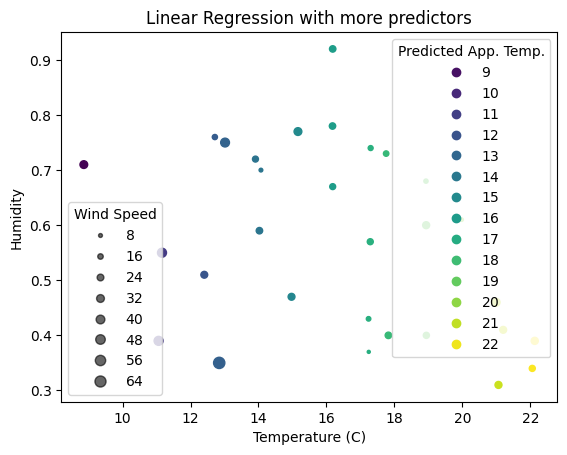

MSE:
26.40820279470182
Log Likelihood:
-215.48262136211974
Weights:
[[-1.00729886]
 [ 1.05330159]
 [ 0.02107207]
 [ 0.00365833]]


In [60]:
#We can also consider more predictors

x = data[["Temperature (C)", "Humidity", "Wind Speed (km/h)"]].to_numpy()
y = data["Apparent Temperature (C)"].to_numpy().reshape(-1,1)

y_pred, w = linear_regression(x,y,linear_basis)

fig, ax = plt.subplots()
scatter = ax.scatter(data["Temperature (C)"], data["Humidity"], s = data["Wind Speed (km/h)"]*2, c = y_pred)
legend1 = ax.legend(*scatter.legend_elements(), loc = 'upper right', title="Predicted App. Temp.")
ax.add_artist(legend1)
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
legend2 = ax.legend(handles, labels, loc = 'lower left', title="Wind Speed")

plt.title("Linear Regression with more predictors")
plt.ylabel("Humidity")
plt.xlabel("Temperature (C)")
plt.show()

print("MSE:")
print(np.mean((y_pred.T-y)**2))
print("Log Likelihood:")
print(-len(y)/2*np.log(2*np.pi)-len(y)/2*np.log(1/beta) - 1/2*beta*np.sum((y_pred.T-y)**2))
print("Weights:")
print(w)

## Bayesian Linear Regression

We now consider a prior distribution on the weights, which in this case is:

$$p(w|\alpha) = \mathcal{N}(w| 0, \alpha^{-1} I)$$

So, we can use Bayes theorem to compute the posterior:

$$    p(w| \underline{x}, \underline{y}, \alpha, \beta) = \frac{p(\underline{y}| \underline{x}, w, \beta) p(w|\alpha)}{p(\underline{y}| \underline{x}, \alpha, \beta)}$$

and notice that it is a Gaussian distribution:

$$p(w|\underline{x}, \underline{y}, \alpha, \beta) = \mathcal{N} (w | m_N, S_N)$$

where 

$$m_N = \beta S_N \Phi^T \underline{y}$$
$$S_N^{-1} = \alpha I + \beta \Phi^T \Phi$$

Once we have the posterior distribution, we can calculate the predictive distribution as:

$$p(y|x, \underline{x} , \underline{y}, \alpha, \beta)  = \mathcal{N} \left(y| m_N^T \phi(x), \sigma_N^2(x) \right)$$

where 

$$\sigma_N^2(x) = \frac{1}{\beta} + \phi^T(x) S_N \phi(x)$$

For simplicity and for visualizing the result, we test on a single predictor.

In [11]:
#Bayesian Regression with alpha and beta fixed and a gaussian prior

def bayesian_linear_regression(x,y,basis_function, alpha, beta):
    N = len(y)
    train_features = basis_function(x)
    X = np.hstack((np.ones((N,1)), train_features))
    SN_inv = alpha*np.eye(X.shape[1]) + beta*X.T @ X
    SN = np.linalg.inv(SN_inv)
    mN = beta * SN @ X.T @ y
    return np.dot(mN.T, X.T), np.sqrt(1/beta + np.diag(X @ SN @ X.T)), mN, SN

def predict_bayesian_linear_regression(mN, SN, N, x, basis_function, beta):
    train_features = basis_function(x)
    X = np.hstack((np.ones((N,1)), train_features))
    mean = np.dot(mN.T, X.T)[0]
    sigma = np.sqrt(1/beta + np.diag(X @ SN @ X.T))
    return mean, sigma

def plot_bayesian_LR(mN, SN, N, x, basis_function, beta):
    mean, sigma = predict_bayesian_linear_regression(mN, SN, N, x, basis_function, beta)
    plt.plot(x.T[0],mean)
    plt.fill_between(x.T[0], mean-sigma, mean+sigma, alpha=0.2)


MSE (training set):
13.800043941030337
Log Likelihood (training set):
-156.15508070937744
MSE (test set):
30.75887862951196
Log Likelihood (test set):
-239.63578395398656


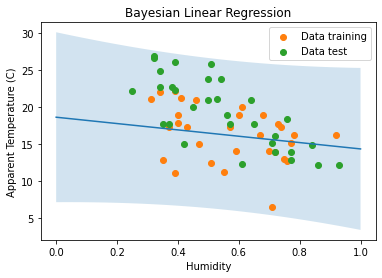

In [12]:
x = data["Humidity"].to_numpy().reshape(-1,1)
y = data["Apparent Temperature (C)"].to_numpy().reshape(-1,1)

x_test = data_test["Humidity"].to_numpy().reshape(-1,1)
y_test = data_test["Apparent Temperature (C)"].to_numpy().reshape(-1,1)

alpha = 0.002

y_pred_bayes, sigma_pred, mN, SN = bayesian_linear_regression(x,y,linear_basis, alpha, beta)

print("MSE (training set):")
print(np.mean((y_pred_bayes-y)**2))
print("Log Likelihood (training set):")
print(-1/2*np.sum(np.log(2*np.pi*sigma_pred**2)) - 1/2*np.sum(((y_pred_bayes-y)**2)/(sigma_pred**2)))

mean, sigma = predict_bayesian_linear_regression(mN, SN, len(x_test), x_test, linear_basis, beta)
print("MSE (test set):")
print(np.mean((mean-y_test)**2))
print("Log Likelihood (test set):")
print(-1/2*np.sum(np.log(2*np.pi*sigma**2)) - 1/2*np.sum(((mean-y_test)**2)/(sigma**2)))

#FOR 1D features, we can plot the regression
xrange=np.linspace(0, 1, 100).reshape(-1,1)
plot_bayesian_LR(mN, SN, len(xrange), xrange, linear_basis, beta)

plt.scatter(data["Humidity"], data["Apparent Temperature (C)"], label='Data training')
plt.scatter(data_test["Humidity"], data_test["Apparent Temperature (C)"], label='Data test')

plt.xlabel("Humidity")
plt.ylabel("Apparent Temperature (C)")
plt.title("Bayesian Linear Regression")
plt.legend()
plt.show()

## Logistic Regression

### The problem

Given observations $(\textbf{x}_i, y_i)$ with $x_i \in \mathbb{R}^d$ and $y_i \in \{0,1\}$ we want to model $p(y | \textbf{x})$.

**Notation**

$\textbf{X}$: the dataset of input features $\textbf{x}_i$

$\textbf{Y}$: the dataset of targets $y_i$

In [13]:
import numpy as np
import os
import requests


# URL of the file to download
url = 'https://raw.githubusercontent.com/DavideScassola/PML2024/main/Notebooks/data/logistic_regression_data.npz'

# Send a HTTP request to the URL of the file
response = requests.get(url)

# Ensure the 'data/' directory exists
os.makedirs('data', exist_ok=True)

# Write the file
with open('data/logistic_regression_data.npz', 'wb') as f:
    f.write(response.content)

# loading the dataset
X = np.load('data/logistic_regression_data.npz')['X']
y = np.load('data/logistic_regression_data.npz')['y']


# let's split it into train and test set and normalize it
def split_and_standardize(*, X, y, ratio=0.8):
    
    # Splitting train and test sets
    cut = int(ratio * len(y))
    X_train = X[:cut]
    y_train = y[:cut]
    
    X_test = X[cut:]
    y_test = y[cut:]
    
    # Standardizing data
    x_mean = X_train.mean(axis=0)
    x_std = X_train.std(axis=0)
    
    X_train = (X_train - x_mean) / x_std
    X_test = (X_test - x_mean) / x_std
    
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = split_and_standardize(X=X, y=y, ratio=0.04)

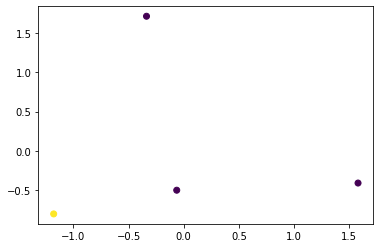

In [14]:
import matplotlib.pyplot as plt

_ = plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

### The model

In logistic regression $p(y | \textbf{x})$ is modelled as:

$$p_{\textbf{w}}(y |  \textbf{x}) = Bernoulli(y; f(\textbf{w}^{T} \textbf{x})) $$

where $f : \mathbb{R} \rightarrow [0,1]$ is usually chosen to be the Logit $ \left( ({1 + e^{-k}})^{-1} \right)$ or the Probit.

Why $\textbf{w}^{T} \textbf{x}$ and not $\textbf{w}^{T} \textbf{x} + h$? For simplicity we prefer to avoid explicitly modelling the bias and we equivalently add a "1" as a feature to each data point. 

In [15]:
import numpy as np

# Add the "bias feature"
X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test])


def logit(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))


def likelihood(X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
    p = logit(X @ w)  # (n, d) @ (d, )
    return np.where(y == 1, p, 1 - p).prod()

### Maximum likelihood fitting (frequentist)

We fit our model $p_{\textbf{w}}(y |  \textbf{x})$ by finding parameters $w$ that maximize the likelihood according to our data. For numerical reasons we equivalently maximize the log-likelihood:

$$ \log{p_{\textbf{w}}(Y |  \textbf{X})} =  \log{ \prod_i {        p_{\textbf{w}}(y_i |  \textbf{x}_i)             }} = \sum_i \log{p_{\textbf{w}}(y_i |  \textbf{x}_i)} = \sum_i \log{Bernoulli(y_i; f(\textbf{w}^{T} \textbf{x}_i))}$$

We can find $w_{ML} = \argmax_{\textbf{w}}  \log{p_{\textbf{w}}(Y |  \textbf{X})}$ using numerical optimization, in particular we can use gradient descent:

$$ w_{n+1} = w_{n} + \eta \nabla_{\textbf{w}} \log{p_{\textbf{w}}(Y |  \textbf{X})} $$

where $\eta$ is the learning rate. How do we compute the gradient? We can compute it analyticallly, but we can also use automatic differentiation with `pytorch`.

In [16]:
import torch
from tqdm.notebook import tqdm

def log_likelihood(*, X: torch.Tensor, y: torch.Tensor, w: torch.Tensor) -> torch.Tensor:
    p = torch.sigmoid(X @ w)
    return torch.where(y == 1, torch.log(p + 1e-8), torch.log(1 - p + 1e-8)).sum()


def gradient_descent_optimization(*, loss_function, lr: float, n_iter: int, initial_guess: np.ndarray) -> np.ndarray:
    w = torch.tensor(initial_guess, dtype=torch.float32, requires_grad=True)
    for _ in tqdm(range(n_iter)):
        loss = loss_function(w)
        loss.backward()
        with torch.no_grad():
            w -= lr * w.grad
        w.grad = None
    print(f"loss={ loss.item():.4g}")
    return w.cpu().detach().numpy()

X_tensor = torch.tensor(X_train, dtype=torch.float32)
y_tensor = torch.tensor(y_train, dtype=torch.float32)
loss_function = lambda w: -log_likelihood(X=X_tensor,
                                          y=y_tensor,
                                          w=w)

w_mle = gradient_descent_optimization(loss_function=loss_function,
                                      initial_guess=np.zeros(X_train.shape[1]),
                                      lr=1e-2,
                                      n_iter=5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

loss=0.09124


In [17]:
# Veryfing the results

from sklearn.metrics import confusion_matrix

def predict(*, x: np.ndarray, w: np.ndarray) -> np.ndarray:
    return logit(x @ w)

def mean_cross_entropy(*, y: np.ndarray, pred: np.ndarray) -> float:
    return -np.where(y, np.log(pred + 1e-8), np.log(1 - pred + 1e-8)).mean()

frequentist_predictions = predict(x=X_train, w=w_mle)
print("confusion matrix: \n", confusion_matrix(y_train, frequentist_predictions > 0.5))
print(f"mean cross entropy: {mean_cross_entropy(y=y_train, pred=frequentist_predictions):.3g}")

confusion matrix: 
 [[3 0]
 [0 1]]
mean cross entropy: 0.0228


### Bayesian inference

In Bayesian Inference, we want to compute the **posterior distribution**:
$$p(\textbf{w} | \mathbf{X}, Y) \propto p(Y | \textbf{w}, \mathbf{X})p(\textbf{w})$$


where $p(\textbf{w})$ is the prior, and the **predictive distribution**:
$$p(y | \mathbf{x}, \mathbf{X}, Y) = \int p(y | \mathbf{x}, \textbf{w}) p(\textbf{w} | \mathbf{X}, Y) d\textbf{w}$$

notice that $\mathbf{X}$ is always in the conditioning, we are not interested in its distribution!

#### Posterior distribution

For the posterior $p(\textbf{w} | \mathbf{X}, Y) \propto p(Y | \textbf{w}, \mathbf{X})p(\textbf{w})$ we resort to the **Laplace Approximation**:

$$p(\textbf{w} | \mathbf{X}, Y) \approx \mathcal{N}(\textbf{w}; \mu_D, \Sigma_D)$$

where $\mu_D = \textbf{w}_{MAP}$ and $\Sigma_D =  \left( - \nabla_w \nabla_w \log{p(\textbf{w}_{MAP} | Y , \mathbf{X})} \right)^{-1}$

where $\textbf{w}_{MAP} = \argmax_{\textbf{w}} \left[ p(\textbf{w} | \mathbf{X}, Y) \right]$ is the **maximum a posteriori**, equivalently $\textbf{w}_{MAP} = \argmax_{\textbf{w}}  \left[ \log{p(Y | \textbf{w}, \mathbf{X})} + \log{p(\textbf{w})} \right]$


In [18]:
# We can assume a Gaussian prior for the weights, with zero mean and a certain diagonal covariance matrix
from torch.distributions import Normal

PRIOR_STD = 100

def log_prior(w):
    return Normal(0, PRIOR_STD).log_prob(w).sum()

def log_unnormalized_posterior(*, X, y, w):
    return log_likelihood(X=X, y=y, w=w) + log_prior(w)

loss_function = lambda w: -(log_unnormalized_posterior(X=X_tensor, y=y_tensor, w=w))

w_map = gradient_descent_optimization(loss_function=loss_function,
                                      initial_guess=np.zeros(X_train.shape[1]),
                                      lr=1e-2,
                                      n_iter=5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

loss=16.67


In [19]:
def compute_hessian(*, f, w):
    w.requires_grad = True
    grad = torch.autograd.grad(f(w), w, create_graph=True)[0]
    hessian = torch.zeros((w.numel(), w.numel()))
    for i in range(w.numel()):
        hessian[i] = torch.autograd.grad(grad[i], w, retain_graph=True)[0]
    w.requires_grad = False
    return hessian

hessian = compute_hessian(f=lambda w : log_unnormalized_posterior(X=X_tensor, y=y_tensor, w=w), w=torch.tensor(w_map, dtype=torch.float32))
posterior_cov = torch.inverse(-hessian).numpy()

In [20]:
w_map

array([-4.1356425, -5.106282 , -1.8804175], dtype=float32)

In [21]:
posterior_cov

array([[ 28.68437 ,  13.253781,  20.485367],
       [ 13.253777,  46.63046 , -17.844376],
       [ 20.485367, -17.844372,  55.99815 ]], dtype=float32)

#### Predictive distribution

The approximation for the **predictive distribution** follows from the Laplace approximation of the posterior approximation (see lecture's notes for more details):
$$p(y | \mathbf{x}, \mathbf{X}, Y) \approx f\left(\kappa\left(\sigma_a^2\right) \mu_a\right)$$

where $\kappa\left(\sigma_a^2\right)=\left(1+\pi \frac{\sigma_a^2}{8}\right)^{-\frac{1}{2}}$ and $\mu_a$ and $\sigma_a^2$ are the mean and variance of the linear combination of the gaussian posterior with the observation $\mathbf{x}$.

So $\mu_a = \mathbf{\mu}_{D}^T \mathbf{x}$ and $\sigma_a^2 = \mathbf{x}^T \Sigma_{D} \mathbf{x}$

In [25]:
def laplace_predictive_distribution(*, x, posterior_mean, posterior_cov):
    mu = x @ posterior_mean # (n, d) @ (d, )
    var = np.diag(x @ posterior_cov @ x.T)
    #var = np.array([X[i] @ posterior_cov @ X[i].T for i in range(len(X))])
    k = (1 + np.pi*var/8)**(-0.5)    
    return logit(mu * k)

bayesian_predictions = laplace_predictive_distribution(x=X_test, posterior_mean=w_map, posterior_cov=posterior_cov)

In [26]:
X = {"train": X_train, "test": X_test}
y = {"train": y_train, "test": y_test}

freq_weights = w_map

predictor = {"frequentist": lambda x : predict(x=x, w=freq_weights),
             "bayesian": lambda x :  laplace_predictive_distribution(x=x, posterior_mean=w_map, posterior_cov=posterior_cov)}

for data in ('train', 'test'):
    for model in ('frequentist', 'bayesian'):
        pred = predictor[model](X[data])
        print(f"{model} {data} mean cross entropy: {mean_cross_entropy(y=y[data], pred=pred):.2f}")
        cm = confusion_matrix(y[data], pred > 0.5) / len(y[data])
        #print(f"{model} {data} confusion matrix: \n", np.round(cm,2))
        print(f"{model} {data} accuracy: {(cm[0,0] + cm[1,1]):.1%}")
        print()

frequentist train mean cross entropy: 0.02
frequentist train accuracy: 100.0%

bayesian train mean cross entropy: 0.34
bayesian train accuracy: 100.0%

frequentist test mean cross entropy: 1.07
frequentist test accuracy: 67.7%

bayesian test mean cross entropy: 0.57
bayesian test accuracy: 67.7%



In [27]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,4)
plt.rcParams["figure.dpi"] = 100

def plot_train_data(X, y):
    plt.scatter(X[y==1][:,1], X_train[y==1][:,2], c = 'red', marker='x', label='1')
    plt.scatter(X[y==0][:,1], X_train[y==0][:,2], c = 'red', marker='o', label='0')
    plt.legend()

def binary_crossentropy(*, true: np.ndarray, pred: np.ndarray):
    return -np.where(true, np.log(pred + 1e-8), np.log(1 - pred + 1e-8)).mean()

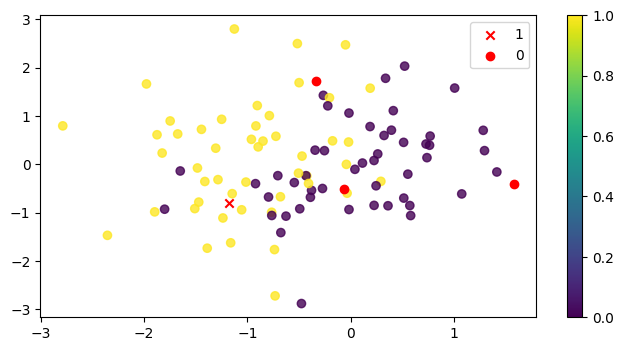

In [28]:
plt.scatter(X_test[:,1], X_test[:,2], c = y_test, alpha = 0.8)
plot_train_data(X_train, y_train)
_ = plt.colorbar()

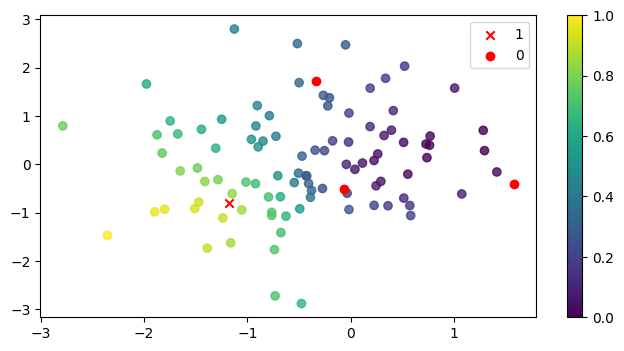

In [29]:
pred = laplace_predictive_distribution(x=X_test, posterior_mean=w_map, posterior_cov=posterior_cov)
error = binary_crossentropy(true=y_test, pred=pred)
plt.scatter(X_test[:,1], X_test[:,2], c = pred, alpha = 0.8)
plot_train_data(X_train, y_train)
_ = plt.colorbar()

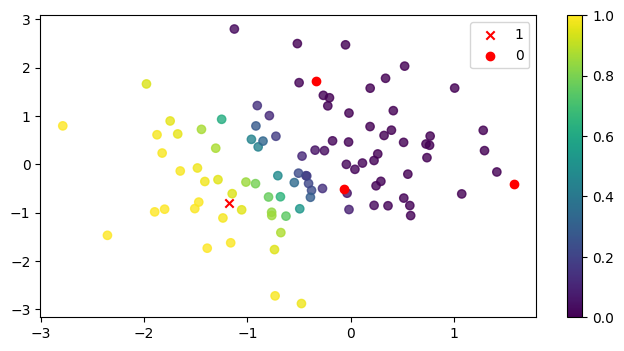

In [30]:
pred = predict(x=X_test, w=freq_weights)
error = binary_crossentropy(true=y_test, pred=pred)
plt.scatter(X_test[:,1], X_test[:,2], c = pred, alpha = 0.8)
plot_train_data(X_train, y_train)
_ = plt.colorbar()

### Exercises

1. Try to repeat the analysis using more points

2. Try to repeat the analysis on the following dataset

In [37]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = data.data
y = data.target 